In [4]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gzip
import numpy as np
import seaborn as sns
import itertools
from IPython.display import Markdown, display
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.preprocessing import StandardScaler

In [5]:
n = 5
with open('data/users.csv') as lines:
  for i in range(n):
    print(next(lines))

ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS

1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0

545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,2017-03-07 10:18:59.427000,ACTIVE,GB,1982,PASSED,0

10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,2018-05-31 04:41:24.672000,ACTIVE,ES,1973,PASSED,0

fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,2018-06-01 17:24:23.852000,ACTIVE,FR,1986,PASSED,0



In [39]:
users = pd.read_csv('data/users.csv')

In [9]:
n = 5
with open('./data/transactions.csv') as transactions:
  for _ in range(n):
    print(next(transactions))

CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,AMOUNT_USD

GBP,4420,COMPLETED,2017-12-10 16:38:55.577,,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0

PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,

GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0

GBP,10000,COMPLETED,2017-12-10 16:34:42.592,,,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0



In [10]:
tr = pd.read_csv('./data/transactions.csv')

In [41]:
df = pd.merge(users, tr, how='inner', left_on='ID', right_on='USER_ID')

### Exploratory Data Analysis and Cleaning

Looking at:
Structure: 
  - Reasonable. Loads correctly.

Granularity: 
  - Transactions is at the individual transaction.  There are multiple per user.
  - User is at the user level.  Single per user.
  - When we merge the two data files, the merged data file takes on the granularity of the transaction

Scope:
 - test

Temporality:
 - test

Faithfulness:
 - I'll walk through each field in the next block to examine if the data looks reasonable and if not, how to address it.



### EDA and Faithfulness
We'll look at the User dataset first.

If I don't mention missing values, it will be because there are none and so nothing to address.  The number of missing values will be seen by the following `.info()` call.

We can actually see that only the `Terms_Version` field has missing values. We will look into the nature of these.

In [42]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       9944 non-null   object
 1   HAS_EMAIL                9944 non-null   int64 
 2   PHONE_COUNTRY            9944 non-null   object
 3   IS_FRAUDSTER             9944 non-null   bool  
 4   TERMS_VERSION            8417 non-null   object
 5   CREATED_DATE             9944 non-null   object
 6   STATE                    9944 non-null   object
 7   COUNTRY                  9944 non-null   object
 8   BIRTH_YEAR               9944 non-null   int64 
 9   KYC                      9944 non-null   object
 10  FAILED_SIGN_IN_ATTEMPTS  9944 non-null   int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 786.7+ KB


Notes: Id
  - It is unique(no counts>1) and so leads me to believe that the granularity of the dataset is at the user level.

In [44]:
users['ID'].value_counts().max()

1

Notes: Has_Email

A boolen in the form of 1/0.

In [45]:
users['HAS_EMAIL'].value_counts()

HAS_EMAIL
1    9414
0     530
Name: count, dtype: int64

Notes: Phone_Country

The highest number by far belongs to `GB...GG`.  It may be interesting to split these out into single countries or otherwise look into this field.

In [46]:
users['PHONE_COUNTRY'].value_counts()

PHONE_COUNTRY
GB||JE||IM||GG    4302
FR                1309
PL                 672
LT                 492
ES                 411
                  ... 
CO                   1
GE                   1
OM                   1
AD                   1
CR                   1
Name: count, Length: 83, dtype: int64

In [47]:
users['PHONE_COUNTRY'].unique()

array(['GB||JE||IM||GG', 'ES', 'FR', 'SI', 'PL', 'BE', 'CH', 'CZ', 'GR',
       'FI||AX', 'CY', 'IE', 'LT', 'US||PR||CA', 'MT', 'HU', 'RO', 'DK',
       'MY', 'DE', 'HR', 'BG', 'PT', 'RU||KZ', 'MK', 'NO||SJ||BV', 'IT',
       'EE', 'LV', 'SE', 'JO', 'SK', 'NL', 'AD', 'AT', 'IN', 'NC', 'ZA',
       'LU', 'GI', 'IS', 'ME', 'BR', 'MX', 'CC||CX||AU', 'NZ', 'TH', 'ID',
       'EH||MA', 'TR', 'OM', 'BL||MF||GP', 'GF', 'GE', 'PE', 'CO', 'MV',
       'MQ', 'QA', 'IL', 'AL', 'VN', 'JP', 'CN', 'AZ', 'KR', 'TF||RE||YT',
       'BN', 'TW', 'MN', 'AR', 'EG', 'HK', 'KG', 'UA', 'CM', 'AE', 'SN',
       'PH', 'MO', 'KY', 'DZ', 'CR'], dtype=object)

Notes: Is_Fraudster

This is our target variable. Only about .2 percent are identified as such.

In [48]:
users['IS_FRAUDSTER'].value_counts()

IS_FRAUDSTER
False    9646
True      298
Name: count, dtype: int64

Notes: Terms_Version

We have a limited number of versions and then about 1000 who have no value.  I will make the assumption that those users have never received or signed a "Terms" agreement rather than that this missing data is just invalid.


In [49]:
users['TERMS_VERSION'].value_counts()

TERMS_VERSION
2018-05-25    3393
2018-09-20    2109
2018-03-20    2048
2018-01-13     440
2018-01-01     232
2017-01-16     121
2017-02-02      74
Name: count, dtype: int64

In [50]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       9944 non-null   object
 1   HAS_EMAIL                9944 non-null   int64 
 2   PHONE_COUNTRY            9944 non-null   object
 3   IS_FRAUDSTER             9944 non-null   bool  
 4   TERMS_VERSION            8417 non-null   object
 5   CREATED_DATE             9944 non-null   object
 6   STATE                    9944 non-null   object
 7   COUNTRY                  9944 non-null   object
 8   BIRTH_YEAR               9944 non-null   int64 
 9   KYC                      9944 non-null   object
 10  FAILED_SIGN_IN_ATTEMPTS  9944 non-null   int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 786.7+ KB


Notes: Created_Date

This will be transformed into a date time.  The value does have both a date and a time.  I'll split it into two fields.  It is possible that there is some relevant information in the time at which the account was created.

In [54]:
users['DT_CREATED_DATETIME'] = pd.to_datetime(users['CREATED_DATE'])
users['DT_CREATED_DATE'] = users['DT_CREATED_DATETIME'].dt.date
users['DT_CREATED_TIME'] = users['DT_CREATED_DATETIME'].dt.time


In [55]:
users['DT_CREATED_DATE'].value_counts()

DT_CREATED_DATE
2018-03-11    62
2017-12-08    58
2018-03-10    57
2018-03-07    49
2018-03-06    47
              ..
2016-01-11     1
2017-01-04     1
2016-04-02     1
2016-12-24     1
2016-02-23     1
Name: count, Length: 930, dtype: int64

Notes: Amount

There are significant outliers.  Looking into this below.

In [15]:
df_m['AMOUNT_USD'].describe()

count    5.861250e+05
mean     6.862871e+03
std      7.502182e+04
min      0.000000e+00
25%      3.470000e+02
50%      1.008000e+03
75%      3.689000e+03
max      1.641211e+07
Name: AMOUNT_USD, dtype: float64

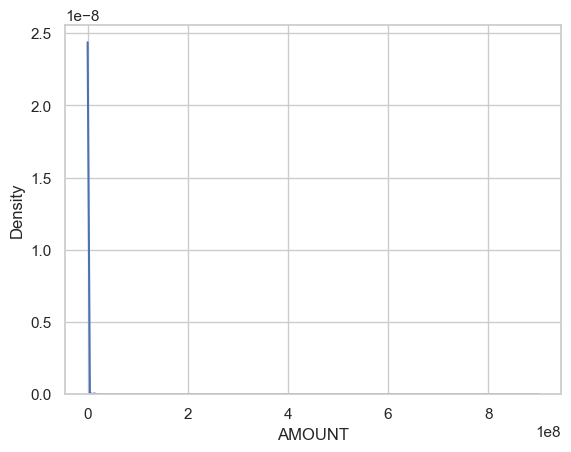

In [16]:
sns.kdeplot(df_m, x="AMOUNT")

plt.show()

In [17]:
median = 1008
std = 71883
high = median + 1.5 * std
low = median - 1.5 * std
print("IQR =", high - low)
print("Highest =", high) 

df_m['OUTLIER_HIGH'] = False
# set outlier_high to True for all rows where AMOUNT_USD is greater than high
df_m.loc[df_m['AMOUNT_USD'] > high, 'OUTLIER_HIGH'] = True



IQR = 215649.0
Highest = 108832.5


In [18]:
df_m["OUTLIER_HIGH"].describe()

count     638742
unique         2
top        False
freq      634853
Name: OUTLIER_HIGH, dtype: object

In [19]:
median = 1393
std = 2380562
high = median + 1.5 * std
low = median - 1.5 * std
print("IQR =", high - low)
print("Highest =", high) 

df_m['OUTLIER_HIGH_2'] = False
# set outlier_high to True for all rows where AMOUNT_USD is greater than high
df_m.loc[df_m['AMOUNT'] > high, 'OUTLIER_HIGH_2'] = True



IQR = 7141686.0
Highest = 3572236.0


In [20]:
df_m["OUTLIER_HIGH_2"].describe()

count     638742
unique         2
top        False
freq      638361
Name: OUTLIER_HIGH_2, dtype: object

In [21]:
df_out2 = df_m[df_m["OUTLIER_HIGH_2"] == True]

In [22]:
test = df_m[df_m['IS_FRAUDSTER'] == True]

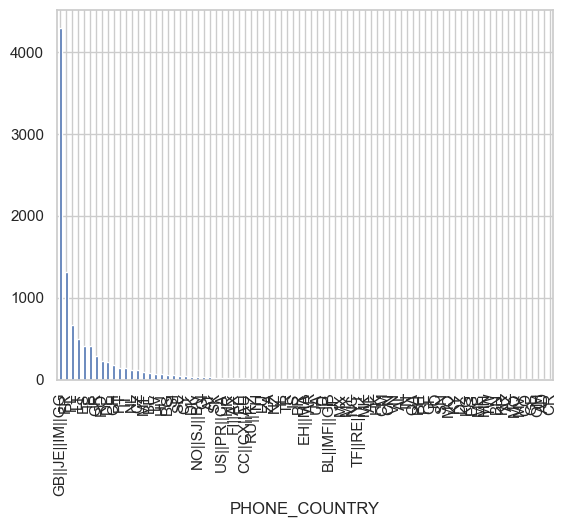

In [23]:
import matplotlib.pyplot as plt
df["PHONE_COUNTRY"].value_counts().plot(kind="bar")
plt.show()



In [24]:
df_m["HAS_MULTIPLE_PHONE_COUNTRIES"] = False

df_m.loc[df_m["PHONE_COUNTRY"].str.len() > 3, "HAS_MULTIPLE_PHONE_COUNTRIES"] = True


In [25]:
res = df_m.pivot_table(index=['HAS_MULTIPLE_PHONE_COUNTRIES'],columns=['IS_FRAUDSTER'],values='USER_ID', aggfunc='count')
res


IS_FRAUDSTER,False,True
HAS_MULTIPLE_PHONE_COUNTRIES,,
False,298508,1069
True,326320,12845


In [26]:
res = df_m.pivot_table(index=['OUTLIER_HIGH'],columns=['IS_FRAUDSTER'],values='USER_ID', aggfunc='count')
res


IS_FRAUDSTER,False,True
OUTLIER_HIGH,,
False,621471,13382
True,3357,532


In [27]:
res = pd.crosstab(index=df_m['OUTLIER_HIGH'],columns=df_m['IS_FRAUDSTER'])
res

IS_FRAUDSTER,False,True
OUTLIER_HIGH,,
False,621471,13382
True,3357,532


In [28]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638742 entries, 0 to 638741
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ID_x                          638742 non-null  object 
 1   HAS_EMAIL                     638742 non-null  int64  
 2   PHONE_COUNTRY                 638742 non-null  object 
 3   IS_FRAUDSTER                  638742 non-null  bool   
 4   TERMS_VERSION                 613084 non-null  object 
 5   CREATED_DATE_x                638742 non-null  object 
 6   STATE_x                       638742 non-null  object 
 7   COUNTRY                       638742 non-null  object 
 8   BIRTH_YEAR                    638742 non-null  int64  
 9   KYC                           638742 non-null  object 
 10  FAILED_SIGN_IN_ATTEMPTS       638742 non-null  int64  
 11  CURRENCY                      638742 non-null  object 
 12  AMOUNT                        638742 non-nul

In [29]:
X = df_m[["HAS_EMAIL", "TERMS_VERSION", "BIRTH_YEAR", "KYC",
            "OUTLIER_HIGH", "OUTLIER_HIGH_2","HAS_MULTIPLE_PHONE_COUNTRIES", "AMOUNT", "AMOUNT_USD"]]
Y = df_m["IS_FRAUDSTER"]

In [30]:

new_cols = pd.get_dummies(X[["TERMS_VERSION", "KYC"]], drop_first=True)
X = pd.concat([X, new_cols], axis=1)

In [31]:
X=X.drop(["TERMS_VERSION", "KYC"], axis=1)
X.columns

Index(['HAS_EMAIL', 'BIRTH_YEAR', 'OUTLIER_HIGH', 'OUTLIER_HIGH_2',
       'HAS_MULTIPLE_PHONE_COUNTRIES', 'AMOUNT', 'AMOUNT_USD',
       'TERMS_VERSION_2017-02-02', 'TERMS_VERSION_2018-01-01',
       'TERMS_VERSION_2018-01-13', 'TERMS_VERSION_2018-03-20',
       'TERMS_VERSION_2018-05-25', 'TERMS_VERSION_2018-09-20', 'KYC_NONE',
       'KYC_PASSED', 'KYC_PENDING'],
      dtype='object')

In [32]:
X_corr = X.corr().abs()
X_corr.head()

,HAS_EMAIL,BIRTH_YEAR,OUTLIER_HIGH,OUTLIER_HIGH_2,HAS_MULTIPLE_PHONE_COUNTRIES,AMOUNT,AMOUNT_USD,TERMS_VERSION_2017-02-02,TERMS_VERSION_2018-01-01,TERMS_VERSION_2018-01-13,TERMS_VERSION_2018-03-20,TERMS_VERSION_2018-05-25,TERMS_VERSION_2018-09-20,KYC_NONE,KYC_PASSED,KYC_PENDING
HAS_EMAIL,1.000000,0.010204,0.006010,0.002546,0.029785,0.001176,0.003532,0.004882,0.011240,0.001469,0.010131,0.026399,0.066403,0.284749,0.227754,0.001153
BIRTH_YEAR,0.010204,1.000000,0.039800,0.011669,0.005100,0.006580,0.035428,0.009935,0.022881,0.041190,0.012849,0.000388,0.014592,0.020418,0.006557,0.047744
OUTLIER_HIGH,0.006010,0.039800,1.000000,0.032708,0.014760,0.014493,0.411499,0.002053,0.000702,0.000864,0.004495,0.001984,0.000295,0.006636,0.008163,0.016221
OUTLIER_HIGH_2,0.002546,0.011669,0.032708,1.000000,0.003944,0.363612,0.776776,0.001707,0.000831,0.000228,0.002500,0.001345,0.002810,0.002143,0.000179,0.003909
HAS_MULTIPLE_PHONE_COUNTRIES,0.029785,0.005100,0.014760,0.003944,1.000000,0.001307,0.012832,0.042592,0.006117,0.031016,0.049581,0.002830,0.078663,0.041715,0.001450,0.041096


<Axes: >

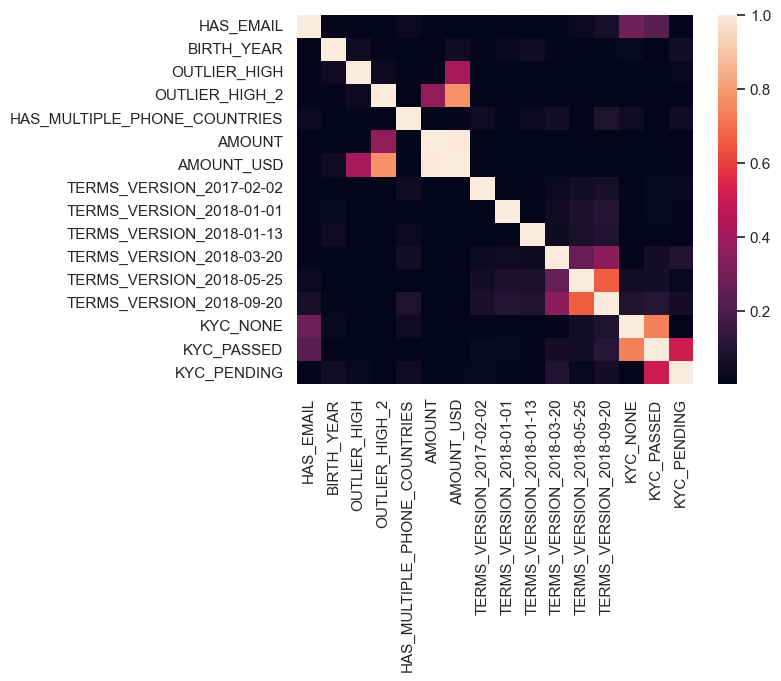

In [33]:
sns.heatmap(X_corr)

In [34]:
# https://h1ros.github.io/posts/drop-highly-correlated-features/
import numpy as np
threshold = 0.9

columns = np.full((X_corr.shape[0],), True, dtype=bool)
for i in range(X_corr.shape[0]):
    for j in range(i+1, X_corr.shape[0]):
        if X_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
selected_columns

X = X[selected_columns]

In [35]:
from sklearn.model_selection import train_test_split
y = Y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train.columns

Index(['HAS_EMAIL', 'BIRTH_YEAR', 'OUTLIER_HIGH', 'OUTLIER_HIGH_2',
       'HAS_MULTIPLE_PHONE_COUNTRIES', 'AMOUNT', 'TERMS_VERSION_2017-02-02',
       'TERMS_VERSION_2018-01-01', 'TERMS_VERSION_2018-01-13',
       'TERMS_VERSION_2018-03-20', 'TERMS_VERSION_2018-05-25',
       'TERMS_VERSION_2018-09-20', 'KYC_NONE', 'KYC_PASSED', 'KYC_PENDING'],
      dtype='object')

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[["AMOUNT", "AMOUNT_USD"]])

KeyError: "['AMOUNT_USD'] not in index"

In [ ]:
X_train[["AMOUNT", "AMOUNT_USD"]] = scaler.transform(X_train[["AMOUNT", "AMOUNT_USD"]])
X_test[["AMOUNT", "AMOUNT_USD"]] = scaler.transform(X_test[["AMOUNT", "AMOUNT_USD"]])

In [ ]:
X_train[["AMOUNT", "AMOUNT_USD"]].describe()

,AMOUNT,AMOUNT_USD
count,5.109930e+05,5.109930e+05
mean,5.909683e-19,-2.989604e-18
std,1.000001e+00,1.000001e+00
min,-1.314640e-02,-9.217558e-02
25%,-1.296059e-02,-8.657169e-02
50%,-1.259217e-02,-7.754159e-02
75%,-1.115276e-02,-4.595074e-02
max,3.588418e+02,2.381765e+02


In [ ]:


from sklearn.linear_model import LogisticRegression
linear = LogisticRegression(max_iter=1000)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test) 



In [ ]:
res = pd.DataFrame(y_pred)
res.value_counts()

False    127327
True        422
Name: count, dtype: int64

In [ ]:
linear.score(X_test, y_test)

0.981111398132275

In [ ]:
from sklearn.metrics import accuracy_score
print("y_pred:", res.value_counts())

print("y_test:", y_test.value_counts())
print("testing accuracy",accuracy_score(y_test, linear.predict(X_test)))


y_pred: False    127327
True        422
Name: count, dtype: int64
y_test: IS_FRAUDSTER
False    124990
True       2759
Name: count, dtype: int64
testing accuracy 0.981111398132275


In [ ]:
y_train_num = y_train.copy().map({True: 1, False: 0})
y_test_num = y_test.copy().map({True: 1, False: 0})



In [ ]:
y_test_num.value_counts()

IS_FRAUDSTER
0    124990
1      2759
Name: count, dtype: int64

In [ ]:

from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV()
clf.fit(X_train, y_train_num)
LR_predictions = clf.predict(X_test)


In [ ]:
print(pd.DataFrame(LR_predictions).value_counts())
print(y_test_num.value_counts())
print ('Accuracy of logistic regression: %d ' % float((np.dot(y_test_num,LR_predictions) + np.dot(1-y_test_num,1-LR_predictions))/float(y_test.size)*100) +
           '% ' + "(percentage of correctly labelled datapoints)")


0    127339
1       410
Name: count, dtype: int64
IS_FRAUDSTER
0    124990
1      2759
Name: count, dtype: int64
Accuracy of logistic regression: 98 % (percentage of correctly labelled datapoints)


In [ ]:
zipped = np.column_stack((LR_predictions, np.array(y_test_num)))


In [ ]:
df_z = pd.DataFrame(zipped)
TP = df_z[(df_z[0] == 1) & (df_z[1] == 1)]
FP = df_z[(df_z[0] == 1) & (df_z[1] == 0)]
FN = df_z[(df_z[0] == 0) & (df_z[1] == 1)]

tp_c = TP.shape[0]
fp_c = FP.shape[0]
fn_c = FN.shape[0]

print('TP:', TP.shape[0])
print('FP:', FP.shape[0])
print('FN:', FN.shape[0])

TP: 378
FP: 32
FN: 2381


In [ ]:
precision = tp_c/(fp_c + tp_c)
recall = tp_c/(tp_c + fn_c)
f1_score = 2 * (precision * recall) / (precision + recall)  
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score) 

Precision:  0.9219512195121952
Recall:  0.13700616165277274
F1 Score:  0.23856106027137897


In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)

print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)


0.04269286412722763
0.01787471174387349
0.13369634155007193


In [ ]:
linear.score(X_test, y_test)

0.1540842778592323

In [ ]:
print(linear.coef_)
print(linear.intercept_)
print(linear.feature_names_in_)

[ 4.75739399e-02  5.21106070e-04  9.81591822e-02 -3.59271927e-02
  2.48587848e-02  2.49643667e-04  1.31549113e-03  1.79518703e-01
  7.66184461e-02  4.71992524e-02  7.04435737e-02  2.68292844e-02
  9.13323933e-03  8.65658843e-02 -1.90928608e-01 -1.49420378e-01
  5.77998936e-01]
-0.9541591533078517
['HAS_EMAIL' 'BIRTH_YEAR' 'OUTLIER_HIGH' 'OUTLIER_HIGH_2'
 'HAS_MULTIPLE_PHONE_COUNTRIES' 'AMOUNT' 'AMOUNT_USD'
 'TERMS_VERSION_2017-02-02' 'TERMS_VERSION_2018-01-01'
 'TERMS_VERSION_2018-01-13' 'TERMS_VERSION_2018-03-20'
 'TERMS_VERSION_2018-05-25' 'TERMS_VERSION_2018-09-20'
 'TERMS_VERSION_missing' 'KYC_NONE' 'KYC_PASSED' 'KYC_PENDING']


In [ ]:
# check multi-collinearity
from sklearn.decomposition import PCA
pca = PCA(n_components=X.shape[1] - 1)
df_pca = pd.DataFrame(pca.fit_transform(X))
df_pca.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,17553.641544,30730.972777,-13.796094,0.833599,-0.329737,-0.307956,-0.062843,0.010509,-0.010547,-0.010540,-0.006430,-0.002836,0.023190,0.000009,-0.000809,-0.001122
1,-7463.312820,14634.292269,-13.872144,0.833377,-0.331596,-0.308082,-0.062916,0.010634,-0.010501,-0.010548,-0.006666,-0.002763,0.016093,-0.000576,-0.000780,-0.001151
2,-30263.401475,-4441.722968,-13.962083,0.833117,-0.333797,-0.308228,-0.063002,0.010782,-0.010447,-0.010557,-0.006946,-0.002676,0.007685,-0.001268,-0.000745,-0.001184
3,-31294.345980,-5338.638475,-13.966311,0.833105,-0.333900,-0.308235,-0.063006,0.010789,-0.010444,-0.010558,-0.006960,-0.002672,0.007290,-0.001300,-0.000743,-0.001186
4,-31484.619504,-5598.438371,-13.967532,0.833101,-0.333930,-0.308237,-0.063007,0.010791,-0.010443,-0.010558,-0.006963,-0.002671,0.007176,-0.001310,-0.000743,-0.001186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638737,-31884.937115,-5900.017361,13.031200,0.176619,-0.547464,0.238231,0.980318,-0.216182,-0.264441,-0.017541,-0.110556,-0.024749,-0.000260,0.018869,-0.012062,-0.004795
638738,-31158.363947,-5355.781722,13.033768,0.176626,-0.547401,0.238235,0.980320,-0.216186,-0.264442,-0.017540,-0.110549,-0.024751,-0.000020,0.018889,-0.012063,-0.004794
638739,-32127.129574,-6082.762573,13.030338,0.176616,-0.547485,0.238230,0.980317,-0.216181,-0.264440,-0.017541,-0.110559,-0.024748,-0.000340,0.018862,-0.012062,-0.004795
638740,-31484.511104,-5495.438367,-26.966813,0.738736,0.647524,-0.129597,-0.022860,-0.004460,-0.012319,-0.011286,-0.003679,0.005071,0.007020,0.012827,0.001588,-0.001398


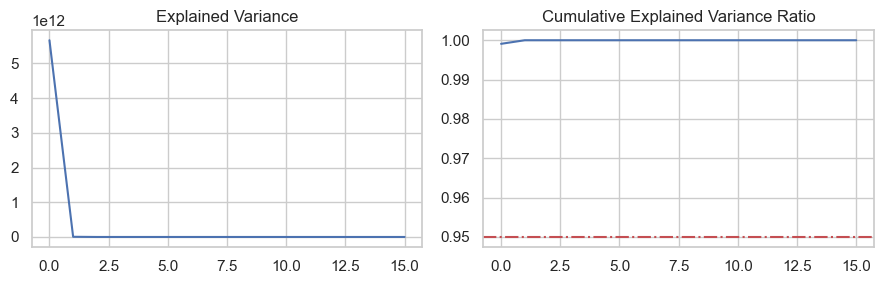

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
axes[0].plot(pca.explained_variance_);
axes[0].set_title('Explained Variance')
axes[1].plot(np.cumsum(pca.explained_variance_ratio_));
axes[1].axhline(y=0.95, c='r', ls='-.')
axes[1].set_title('Cumulative Explained Variance Ratio')
plt.tight_layout()

In [ ]:
pca = PCA(n_components=2, copy=True, whiten=False, tol=0.0)
pca.fit(X)
X_pca = pca.transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)



In [ ]:
y_train.shape

(510993,)

In [ ]:
pca_linear = LinearRegression()
pca_linear.fit(X_train, y_train)
y_pred = pca_linear.predict(X_test)

In [ ]:
y_test.value_counts()

IS_FRAUDSTER
False    124990
True       2759
Name: count, dtype: int64

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred_pca = y_pred[y_pred[0] > .1]

In [ ]:
y_pred_pca.value_counts()

0.807761    14
0.807763    11
0.802552     7
0.819715     6
0.180045     5
            ..
0.171787     1
0.171713     1
0.171711     1
0.171626     1
0.914429     1
Name: count, Length: 1791, dtype: int64

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(pca_linear.score(X_test, y_test))
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

4.2562862611172925e-05
MAE:  0.042455205029876396
MSE:  0.021129706514662627
RMSE:  0.14536060853842978


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

tree_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

tree_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import accuracy_score
print("Decision Tree training accuracy",accuracy_score(y_train, tree_model.predict(X_train)))
print("Random Forest training accuracy",accuracy_score(y_train, rf_model.predict(X_train)))

Decision Tree training accuracy 0.9970312704870713
Random Forest training accuracy 0.9970195286432495


In [ ]:
from sklearn.metrics import accuracy_score
print("Decision Tree testing accuracy",accuracy_score(y_test, tree_model.predict(X_test)))
print("Random Forest testing accuracy",accuracy_score(y_test, rf_model.predict(X_test)))

Decision Tree testing accuracy 0.9828178694158075
Random Forest testing accuracy 0.9861603613335526


In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
res = pd.DataFrame(y_pred)
res.value_counts()

False    125614
True       2135
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

IS_FRAUDSTER
False    124990
True       2759
Name: count, dtype: int64